In [2]:
#imports for PCA, ElasticNet, DecisionTree, GradientBoosting for regression
import time 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# gaussian svr
from sklearn.svm import SVR
#LOO cross validation
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from scipy import stats
from scipy.stats import sem
import random
from xgboost import XGBRegressor

In [53]:
main_path= "D:/Year 4/HONS/Auto_QA_gestures/"
jerks_path = main_path + "Dataset/Appropriateness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path =main_path +  "Dataset/Appropriateness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path =main_path +  "Dataset/Appropriateness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

rms_properties_path =main_path +  "Dataset/Appropriateness_Features/RMS_Energy_properties.csv"
XX_rms_energy_properties = pd.read_csv(rms_properties_path, index_col = False) # With Name of StudySeq

rms_distance_path =main_path +  "Dataset/Appropriateness_Features/RMS_Distance_scores_fd_scaled.csv"
XX_rms_distance_scores = pd.read_csv(rms_distance_path)
XX_rms_distance_scores.drop(XX_rms_distance_scores.columns[1], axis=1, inplace=True) # Dropping the Spine joint (always 0)

spectral_properties_path =main_path +  "Dataset/Appropriateness_Features/Mean_Spectral_Centroid_over_time.csv"
XX_spectral_properties = pd.read_csv(spectral_properties_path, index_col = False) 
print(XX_spectral_properties.columns)

msc_props_path = main_path + "Dataset/Appropriateness_Features/Mean_Spectral_Centroid_props.csv"
XX_msc_properties = pd.read_csv(msc_props_path, index_col = False)

mfcc_path =main_path +  "Dataset/Appropriateness_Features/Mean_MFCC_over_time.csv"
XX_mfcc = pd.read_csv(mfcc_path, index_col = False)

msc_distance_path = main_path + "Dataset/Appropriateness_Features/MSC_Distance_scores_fd_scaled.csv"
XX_msc_distance_scores = pd.read_csv(msc_distance_path, index_col = False)

msbw_distance_path = main_path + "Dataset/Appropriateness_Features/MSBW_Distance_scores_fd_scaled.csv"
XX_msbw_distance_scores = pd.read_csv(msbw_distance_path, index_col = False)

labels_path = main_path + "Dataset/Appropriateness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"
print(YY.columns)

Index(['Unnamed: 0', 'StudySeq', 'Mean_Spectral_Centroid1',
       'Mean_Spectral_Centroid2', 'Mean_Spectral_Centroid3',
       'Mean_Spectral_Centroid4', 'Mean_Spectral_Centroid5',
       'Mean_Spectral_Centroid6', 'Mean_Spectral_Centroid7',
       'Mean_Spectral_Centroid8', 'Mean_Spectral_Centroid9',
       'Mean_Spectral_Centroid10'],
      dtype='object')
Index(['Unnamed: 0', 'Mean_Appropriateness_Score'], dtype='object')


In [54]:
# Merging the features
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})
XY = XY.join(XX_rms_distance_scores)
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_rms_distance_scores'})
# Join the RMS Energy Properties Features
XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['StudySeq'] = XY['StudySeq'].apply(lambda x: x[8:])
XY = XY.join(XX_rms_energy_properties, rsuffix='_rms')
for i in range(1, int(XY.shape[0] / 40)):
    XY.iloc[i * 40:(i + 1) * 40, -5:] = XX_rms_energy_properties
# join the spectral properties
#find overlapping columns between XY and XX_spectral_properties
XY = XY.join(XX_spectral_properties, rsuffix='_spectral')
#duplicate the spectral properties for each study sequence 
for i in range(1, int(XY.shape[0] / 40)):
    XY.iloc[i * 40:(i + 1) * 40, -12:] = XX_spectral_properties

# #join the mfcc features
# XY = XY.join(XX_mfcc, rsuffix='_mfcc')
# #duplicate the mfcc features for each study sequence
# for i in range(1, int(XY.shape[0] / 40)):
#     XY.iloc[i * 40:(i + 1) * 40, -12:] = XX_mfcc
    
XY = XY.join(XX_msc_properties, rsuffix='_msc')
#duplicate the mfcc features for each study sequence
for i in range(1, int(XY.shape[0] / 40)):
    XY.iloc[i * 40:(i + 1) * 40, -5:] = XX_msc_properties
    
XY = XY.join(XX_msc_distance_scores, rsuffix='_msc_dist')

XY = XY.join(XX_msbw_distance_scores, rsuffix='_msbw_dist')


# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
# Also Drop the Index from rms_energy
XY.drop(['Unnamed: 0_YY', 'Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels',
         'Unnamed: 0_rms_distance_scores', 'Unnamed: 0', 'StudySeq_rms','StudySeq_msc' , 'Unnamed: 0_msc', 'Unnamed: 0_spectral', 'StudySeq_spectral', 'Unnamed: 0_msc_dist' , 'Unnamed: 0_msbw_dist'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)

XY = XY.drop(['StudySeq_jerks'], axis=1, inplace=False)
# Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + 14 RMS Energy Distance Scores + 3 RMS Energy Property Features + Label for MOS = 137
XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
#print row 35 to 45

for col in XX.columns:
    print(col)

Spine1_jerks
Spine2_jerks
Spine3_jerks
LeftShoulder_jerks
LeftArm_jerks
LeftForearm_jerks
LeftHand_jerks
RightShoulder_jerks
RightArm_jerks
RightForearm_jerks
RightHand_jerks
Neck_jerks
Neck1_jerks
Head
Spine1_accels
Spine2_accels
Spine3_accels
LeftShoulder_accels
LeftArm_accels
LeftForearm_accels
LeftHand_accels
RightShoulder_accels
RightArm_accels
RightForearm_accels
RightHand_accels
Neck_accels
Neck1_accels
Head_accels
Spine1_vs_Spine2
Spine1_vs_Spine3
Spine1_vs_LeftShoulder
Spine1_vs_LeftArm
Spine1_vs_LeftForeArm
Spine1_vs_LeftHand
Spine1_vs_RightShoulder
Spine1_vs_RightArm
Spine1_vs_RightForeArm
Spine1_vs_RightHand
Spine1_vs_Neck
Spine1_vs_Neck1
Spine1_vs_Head
Spine2_vs_Spine3
Spine2_vs_LeftShoulder
Spine2_vs_LeftArm
Spine2_vs_LeftForeArm
Spine2_vs_LeftHand
Spine2_vs_RightShoulder
Spine2_vs_RightArm
Spine2_vs_RightForeArm
Spine2_vs_RightHand
Spine2_vs_Neck
Spine2_vs_Neck1
Spine2_vs_Head
Spine3_vs_LeftShoulder
Spine3_vs_LeftArm
Spine3_vs_LeftForeArm
Spine3_vs_LeftHand
Spine3_vs_Rig

In [55]:
XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
bad_features = ['LeftShoulder_vs_LeftArm', 'LeftArm_vs_LeftForeArm', 'LeftForeArm_vs_LeftHand',
                'RightShoulder_vs_RightArm', 'RightArm_vs_RightForeArm','RightForeArm_vs_RightHand']
XX.drop(bad_features, axis=1, inplace=True)
YY = XY.loc[:,'Mean_Appropriateness_Score']
for i in range(1,11):
    XX[f'Mean_Spectral_Centroid{i}'] = pd.to_numeric(XX[f'Mean_Spectral_Centroid{i}'], errors='coerce')
    #find data type of Mean spectral centroid column
    print(XX[f'Mean_Spectral_Centroid{i}'].head())
numeric_columns = XX.select_dtypes(include=[np.number]).columns.tolist()
print(numeric_columns)
#do log scaling of all features
# XX = np.log(XX)
XX.iloc[:,-17:-3] = XX.iloc[:,-17:-3]
print(XX.shape)
print(YY.shape)
print(XX.head())

0    1581.553631
1    1886.272151
2    1992.480506
3    2077.878866
4    1767.230737
Name: Mean_Spectral_Centroid1, dtype: float64
0    1856.858500
1    1176.060631
2    2013.262526
3    2042.350654
4    1845.739558
Name: Mean_Spectral_Centroid2, dtype: float64
0    1613.227132
1    1455.218458
2    2005.625374
3    1507.400860
4    2154.118340
Name: Mean_Spectral_Centroid3, dtype: float64
0    1847.308838
1    1238.302652
2    2363.009487
3    1538.073381
4    2054.317002
Name: Mean_Spectral_Centroid4, dtype: float64
0    1906.900318
1    1878.034121
2    2834.440471
3    2116.445918
4    1172.974369
Name: Mean_Spectral_Centroid5, dtype: float64
0    1987.519331
1    2287.425252
2    1789.121860
3    2084.355579
4    1225.704655
Name: Mean_Spectral_Centroid6, dtype: float64
0    1799.152636
1    1794.904255
2    2111.369344
3    1844.902965
4    1710.545890
Name: Mean_Spectral_Centroid7, dtype: float64
0    1522.074641
1    2475.311124
2    1242.542542
3    2050.473720
4    2067.76590

In [65]:
XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.2, random_state=20)

In [66]:
scaler = StandardScaler()
scaler.fit(XX_train)
XX_train = scaler.transform(XX_train)
XX_test = scaler.transform(XX_test)

In [9]:
def learning_curve(model_name, model, XX, YY, param_grid, xticks, log_bool):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        
        inner_val_scores = []
        inner_train_scores = []
        for train_set_size in param_grid:
            val_scores = []
            train_scores = []
            inner_loop_cv = KFold(n_splits = n_splits, shuffle = True)
            inner_folds = inner_loop_cv.split(XX_train)
            for inner_train, val in inner_folds: # cross validation for the given train set size with the given train set
                train_indexes = random.sample(inner_train.tolist(), int(train_set_size))
                XX_train_reduced = XX_train.iloc[train_indexes]
                YY_train_reduced = YY_train.iloc[train_indexes]
                XX_val = XX_train.iloc[val]
                YY_val = YY_train.iloc[val]
                
                YY_train_reduced = YY_train_reduced.values.flatten()
                YY_val = YY_val.values.flatten()
                
                model.fit(XX_train_reduced, YY_train_reduced)
                val_scores = val_scores + [mean_squared_error(YY_val, np.clip(model.predict(XX_val), 0, 100), squared=True)]
                train_scores = train_scores + [mean_squared_error(YY_train_reduced, 
                                                                  np.clip(model.predict(XX_train_reduced), 0, 100),
                                                                  squared=True)]
            inner_val_scores = inner_val_scores + [np.mean(val_scores)]
            inner_train_scores = inner_train_scores + [np.mean(train_scores)]
        outer_val_mse = outer_val_mse + [inner_val_scores]
        outer_train_mse = outer_train_mse + [inner_train_scores]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)

    plt.figure(figsize=(6,4))
    plt.plot(param_grid, mean_train_mse, label='MSE on Training Set')
    plt.plot(param_grid, mean_val_mse, label='MSE on Validation Set')
    plt.xlim(min(param_grid), max(param_grid))
    if (log_bool == False):
        plt.xticks(xticks)
    if (log_bool == True):
        plt.xscale('log')
    plt.ylim(0, max(mean_val_mse) + max(mean_val_mse)*0.05)
    plt.ylabel('MSE')
    plt.xlabel('Number of Observations in the Training Set')
    plt.title(model_name + ' performance\n on different Training Set sizes')
    plt.legend()
    
    print('Best Training Set Size: ', int(param_grid[np.where(mean_val_mse == (min(mean_val_mse)))[0]]))

In [10]:
def validation_curve(model_name, model, XX, YY, param_grid, log_bool, extra_string, xticks):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        YY_train = YY_train.values.flatten()
        
        cv_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "neg_mean_squared_error", 
                                    cv = KFold(n_splits = 5, shuffle = True), return_train_score=True)
        cv_model.fit(XX_train, YY_train)
        
        train_mse = -1 * cv_model.cv_results_["mean_train_score"]
        val_mse = -1 * cv_model.cv_results_["mean_test_score"]
        
        outer_train_mse = outer_train_mse + [train_mse]
        outer_val_mse = outer_val_mse + [val_mse]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    
    train_mse_sem = sem(np.asarray(outer_train_mse), axis=0)
    val_mse_sem = sem(np.asarray(outer_val_mse), axis=0)
    
    param_list = list(np.concatenate(list(param_grid.values())).flat)
    
    plt.figure(figsize = (6,4))
    plt.plot(param_list, mean_train_mse, label='Training Set MSE')
    plt.fill_between(param_list, mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(param_list, mean_val_mse, label='Validation Set MSE')
    plt.fill_between(param_list, mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    if log_bool == True:
        plt.xscale('log')
    plt.xlim(min(param_list),max(param_list))
    plt.xticks(xticks)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.ylabel('MSE')
    plt.xlabel(list(param_grid.keys())[0])
    plt.title(model_name + ' performance on varying ' + list(param_grid.keys())[0] + extra_string)
    plt.legend()
    

In [11]:
# Model name is just the type of algorithm e.g. Linear Regression or kNN
def predicted_vs_true(model_name, model, XX, YY):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    folds = outer_loop_cv.split(XX)
    count = 1
    YY_train_true = []
    YY_train_preds = []
    YY_preds = []
    YY_true = []
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        XX_test= XX.iloc[test]
        YY_test = YY.iloc[test]
        YY_train, YY_test = YY_train.values.flatten(), YY_test.values.flatten()
        
        model.fit(XX_train, YY_train)
        
        YY_train_preds = YY_train_preds + list(model.predict(XX_train))
        YY_train_true = YY_train_true + list(YY_train)
        
        YY_pred = model.predict(XX_test)
        
        YY_true = YY_true + list(YY_test)
        YY_preds = YY_preds + list(YY_pred)
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
    
    
    m, b = np.polyfit(YY_preds, YY_true, 1)
    x = np.arange(0,101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.scatter(YY_preds, YY_true, s=7.5, alpha=0.8, label='Predictions')
    plt.plot(x, y*m + b, '-c', label="Regression Line for predictions")
    plt.plot(x, y, "-k", label="Regression Line for p=1", alpha=0.5)
    plt.title("Predictions of " + model_name + " Model on Test Set")
    plt.ylabel("True Appropriateness")
    plt.xlabel("Predicted Appropriateness")
    plt.xticks(np.linspace(0,100,11))
    plt.yticks(np.linspace(0,100,11))
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()

    rho, pval = stats.spearmanr(YY_true, YY_preds)
    print("Pearson Correlation Coefficient =", rho)
    print("Test Mean Squared Error = ", mean_squared_error(YY_true, YY_preds, squared=True))
    print("Train Mean Squared Error = ", mean_squared_error(YY_train_true, YY_train_preds, squared=True))

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Training Set Size:  224
Time taken:  60.73688554763794


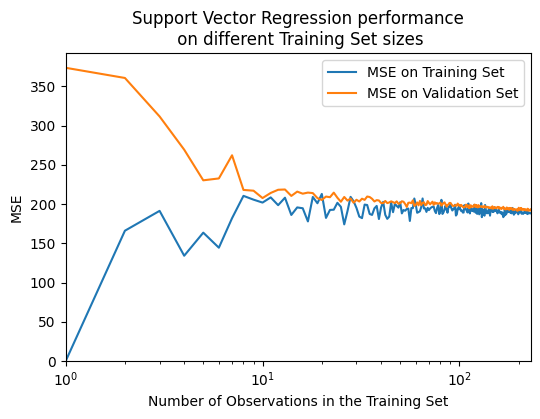

In [18]:
start_time = time.time()
svr = SVR(kernel = "rbf", cache_size=7000)
# No hyperparameter tuning since it would take far too long
learning_curve('Support Vector Regression', svr, XX, YY, np.linspace(1,230,230), np.linspace(0,225,10), True)
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Training Set Size:  229
Time taken:  59.980093002319336


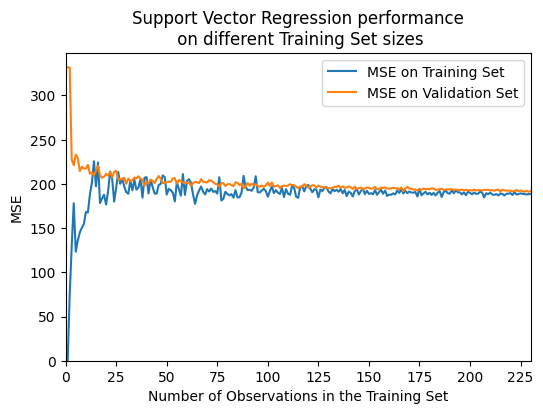

In [19]:
start_time = time.time()
svr = SVR(kernel = "rbf", cache_size=7000)
# No hyperparameter tuning since it would take far too long
learning_curve('Support Vector Regression', svr, XX, YY, np.linspace(1,230,230), np.linspace(0,225,10), False)
print("Time taken: ", time.time() - start_time)

In [13]:
start_time = time.time()

param_grid = {"C": np.logspace(-3, 6, num=10), "gamma": np.logspace(-9, 4, num=14), "epsilon": np.logspace(-3, 6, num=10)}

svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error")

svr.fit(XX_train, YY_train)

svr_init_params = svr.best_params_

print("Time taken: ", time.time() - start_time)

Time taken:  45.697062492370605


In [14]:
print(svr.best_params_)

{'C': 1000000.0, 'epsilon': 10.0, 'gamma': 1e-07}


In [ ]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], C = svr_init_params['C'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"epsilon": np.linspace(0, 50, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY, param_grid, False, extra_string, np.linspace(0, 50, num=11))
print("Time taken: ", time.time() - start_time)

In [ ]:
start_time = time.time()
svr = SVR(kernel = "rbf", epsilon = svr_init_params['epsilon'], C = svr_init_params['C'])
extra_string = '\nfor epsilon = ' + str(svr_init_params['epsilon']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"gamma": np.logspace(-4, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY, param_grid, True, extra_string, np.logspace(-4, 3, num=8))
print("Time taken: ", time.time() - start_time)

In [ ]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], epsilon = svr_init_params['epsilon'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and epsilon = ' + str(svr_init_params['epsilon'])
param_grid = {"C": np.logspace(-3, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY, param_grid, True, extra_string, np.logspace(-3, 3, num=7))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = -0.09813125340418868
Test Mean Squared Error =  201.29584457069683
Train Mean Squared Error =  178.14203050801788
Time taken:  1196.9706099033356


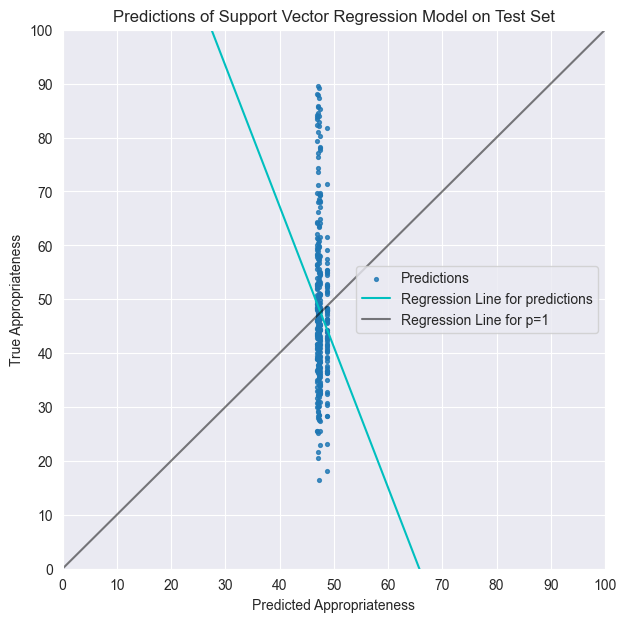

In [45]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"C": np.logspace(-3, 3, num=20), "gamma": np.logspace(-4, 3, num=20), "epsilon": np.linspace(0, 50, num=20)}
svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Support Vector Regression', svr, XX, YY)
print("Time taken: ", time.time() - start_time)

# XGBOOST

In [ ]:
start_time = time.time()

param_grid = {'n_estimators': np.arange(100, 1000, 100), 'learning_rate': np.linspace(0.01, 0.1, 10)}

# Instantiate a xgboost regressor: xgb
xgb= XGBRegressor()

# Instantiate the GridSearchCV object: xgb_cv
xgb_cv = GridSearchCV(xgb, param_grid, cv=5)

# Fit it to the data
xgb_cv.fit(XX_train, YY_train)

# Predict on the test set and compute metrics
y_pred = xgb_cv.predict(XX_test)
mse = mean_squared_error(YY_test, y_pred)
print("Tuned XGBoost MSE: {}".format(mse))


In [81]:
#create parameter grid for gradient boosting
param_grid = {'n_estimators': np.arange(100, 1000, 100), 'learning_rate': np.linspace(0.01, 0.1, 10)}
#instantiate a gradient boosting regressor
gb = GradientBoostingRegressor()
#instantiate a grid search cv object
gb_cv = GridSearchCV(gb, param_grid, cv=5)
#fit the model to the training data
gb_cv.fit(XX_train, YY_train)
#predict the test set
y_pred = gb_cv.predict(XX_test)
#compute the mean squared error
mse = mean_squared_error(YY_test, y_pred)
print("Test set MSE of gb: {:.2f}".format(mse))
#print the best parameters
print("Tuned Gradient Boosting Parameters: {}".format(gb_cv.best_params_))

KeyboardInterrupt: 

# Decision Tree

In [67]:
#create decision tree regressor
#create hyperparameter grid
param_grid = {'max_depth': np.arange(3, 10), 'min_samples_leaf': np.arange(0.1, 0.9, 0.1)}
#instantiate a decision tree regressor
dt = DecisionTreeRegressor()
#instantiate a grid search cv object
dt_cv = GridSearchCV(dt, param_grid, cv=5)
#fit the model to the training data
dt_cv.fit(XX_train, YY_train)
#predict the test set
y_pred = dt_cv.predict(XX_test)
#compute the mean squared error
mse = mean_squared_error(YY_test, y_pred)
print("Test set MSE of dt: {:.2f}".format(mse))
#print the best parameters
print("Tuned Decision Tree Parameters: {}".format(dt_cv.best_params_))


Test set MSE of dt: 107.70
Tuned Decision Tree Parameters: {'max_depth': 8, 'min_samples_leaf': 0.2}


Test set MSE of dt: 103.35
Tuned Decision Tree Parameters: {'max_depth': 7, 'max_features': 54, 'min_samples_leaf': 0.2}


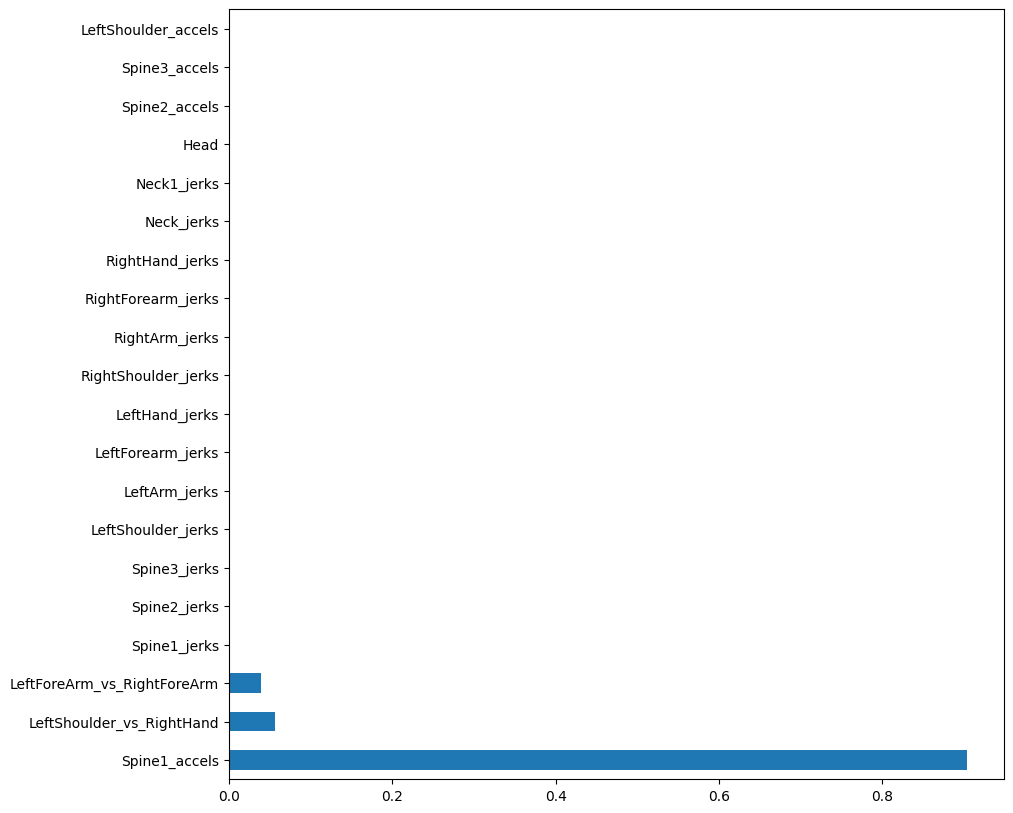

In [72]:
#create decision tree regressor
#create hyperparameter grid
param_grid = {'max_depth': np.arange(3, 10), 'min_samples_leaf': np.arange(0.1, 0.9, 0.1), 'max_features': np.arange(1, 100)}
#instantiate a decision tree regressor
dt = DecisionTreeRegressor()
#instantiate a grid search cv object
dt_cv = GridSearchCV(dt, param_grid, cv=5)
#fit the model to the training data
dt_cv.fit(XX_train, YY_train)
#predict the test set
y_pred = dt_cv.predict(XX_test)
#compute the mean squared error
mse = mean_squared_error(YY_test, y_pred)
print("Test set MSE of dt: {:.2f}".format(mse))
#print the best parameters
print("Tuned Decision Tree Parameters: {}".format(dt_cv.best_params_))
#plot the feature importances
plt.figure(figsize=(10, 10))
feat_importances = pd.Series(dt_cv.best_estimator_.feature_importances_, index=XX.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.39207558204813725
Test Mean Squared Error =  150.1569951339716
Train Mean Squared Error =  126.51624696975465
Time taken:  319.98231506347656


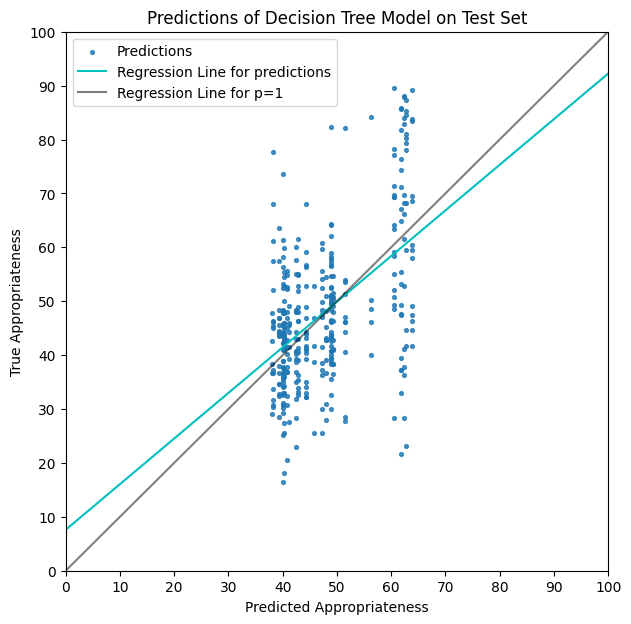

In [75]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {'max_depth': np.arange(3, 10), 'min_samples_leaf': np.arange(0.1, 0.9, 0.1), 'max_features': np.arange(1, 170,5)}
dt = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Decision Tree', dt, XX, YY)
print("Time taken: ", time.time() - start_time)


Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.4865546800923163
Test Mean Squared Error =  129.74118988754662
Train Mean Squared Error =  111.0922986027498
Time taken:  13.488418579101562


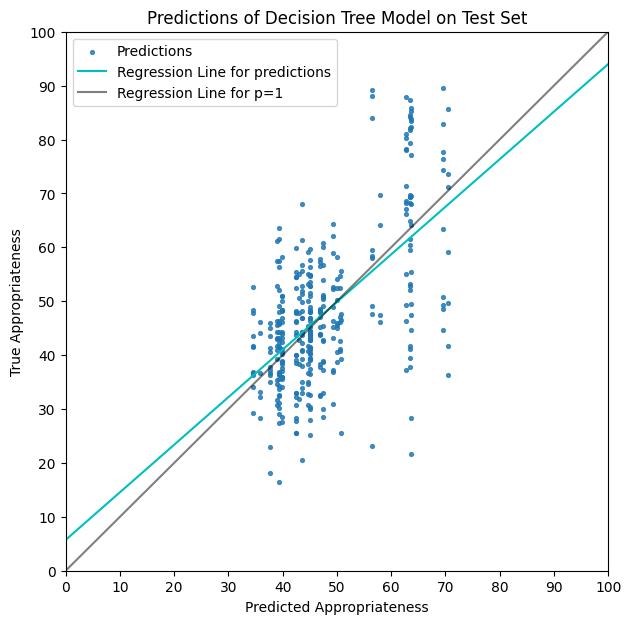

In [70]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {'max_depth': np.arange(3, 10), 'min_samples_leaf': np.arange(0.1, 0.9, 0.1)}
dt = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Decision Tree', dt, XX, YY)
print("Time taken: ", time.time() - start_time)


# Ridge Regression

C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.45825e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.2826e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.03606e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.88748e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\sit

Fold  1 / 5  Complete.


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.25343e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.09349e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.52252e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.71216e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\si

Fold  2 / 5  Complete.


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.37554e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.84262e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.54281e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.02061e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\si

Fold  3 / 5  Complete.


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.86765e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.11529e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.55649e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.46763e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\si

Fold  4 / 5  Complete.


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.55919e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.49349e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.17564e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.33128e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\goyal\anaconda3\envs\mlp\lib\si

Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.5326952706066027
Test Mean Squared Error =  157.9778663322307
Train Mean Squared Error =  102.30103300600192
Time taken:  10.601059913635254


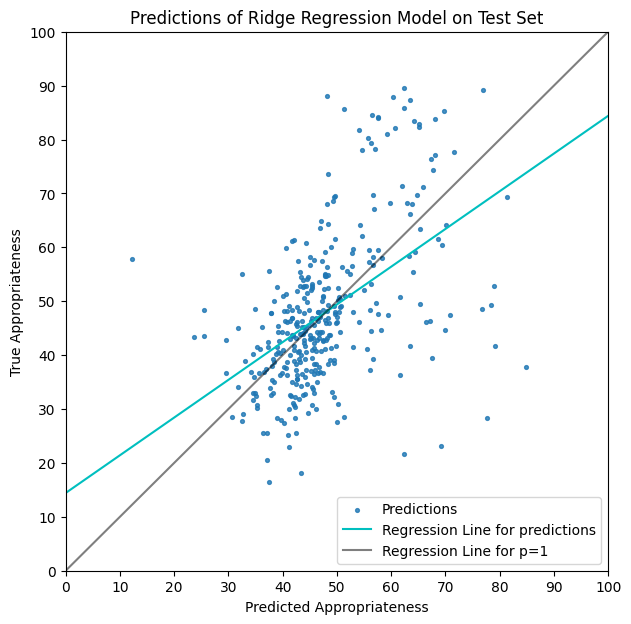

In [15]:
from sklearn.linear_model import Ridge

start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-6,3, 1000)}
ridge_model = GridSearchCV(estimator = Ridge(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Ridge Regression', ridge_model, XX, YY)
print("Time taken: ", time.time() - start_time)

# elastic net

In [12]:
# create elastic net regressor
elastic_net = ElasticNet(max_iter=1500)
# create hyperparameter grid
param_grid = {'alpha': np.logspace(-5, 5, 100), 'l1_ratio': np.linspace(0.1, 0.9, 90)}
# instantiate a grid search cv object
elastic_net_cv = GridSearchCV(elastic_net, param_grid, cv=5)
# fit the model to the training data
elastic_net_cv.fit(XX_train, YY_train)
# predict the test set
y_pred = elastic_net_cv.predict(XX_test)
# compute the mean squared error
mse = mean_squared_error(YY_test, y_pred)
print("Test set MSE of elastic net: {:.2f}".format(mse))
# print the best parameters
print("Tuned Elastic Net Parameters: {}".format(elastic_net_cv.best_params_))


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.811e+03, tolerance: 4.313e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e+03, tolerance: 4.227e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Test set MSE of elastic net: 173.27
Tuned Elastic Net Parameters: {'alpha': 2.848035868435799, 'l1_ratio': 0.1449438202247191}
